# <font color=#295172>Part 2 of 4 - Data Preprocessing</font>

#### <font color=#6185a0>| Final Capstone Project for the Diploma Program in Data Science | BrainStation Vancouver |</font>

<font color=#6185a0>| Arash Tavassoli | May-June 2019 |</font>

---
This is the second notebook in a series of four:
* **Part 1 - Exploratory Data Analysis**

* **<font color=#cc6900>Part 2 - Data Preprocessing</font>**

* **Part 3 - Model Training and Analysis**

* **Part 4 - Real-Time Facial Expression Recognition**

### What to expect in this notebook:

1. Preprocessing the images:
    - Converting to Grayscale
    - Resizing to 100 x 100 pixels
2. Dealing with Class Imbalance:
    - Augmenting the Minority Classes
    - Under-sampling the Majority Classes
3. Scaling the Images
4. Splitting into Train, Validation and Test sets
5. Preparing the Data for Keras    

---
## 1. Loading Data from Previous Notebook (Part 1)
Let's load the csv files that we processed and saved in Part 1, but before that let's load the libraries that will be used in this part:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import seaborn as sns
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sys import getsizeof

In [3]:
# Read the file list from Part 1:
file_list = pd.read_csv('data/file_list.csv', index_col=[0])
# Read the expression summary list from Part 1:
expression_summary = pd.read_csv('data/expression_summary.csv', index_col=[0])

We also define the root directory for where the images are saved:

In [9]:
root_dir = '/Volumes/Arash External Drive/AffectNet Data/'

---
## 2. Helper functions
The following helper functions are defined here and will be used in the following sections:

### 2.1. Image Processor
This function converts a given image to grayscale and resize it to a given size:

In [4]:
# A function to convert an image from RGB ro grayscale, then resize to a desired size:
def image_processor(image, final_size):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
    image = cv2.resize(image, final_size)
    return image

### 2.2. Image Loader
This function imports the images and their associated expressions given the file list and root directory (where images are saved):

In [5]:
# Function to read images and save as numpy arrays:
def image_loader(file_list, root_dir):    
    final_size = (100,100)
    total_images = file_list.shape[0]   
   
    images = []        # List to contain loaded images
    expressions = []   # List to contain corresponding expressions
    error_list = []    # List to contain filepath for corrupted images (if any)
    counter = 0

    for filepath, annotation, expression in zip(file_list['subDirectory_filePath'], 
                                                file_list['annotation'], 
                                                file_list['expression']):
        if annotation == 'manual':
            root_dir = root_dir + 'Manually_Annotated_compressed/Manually Annotated Images/'
        elif annotation == 'auto':
            root_dir = root_dir + 'Automatically_Annotated_compressed/Automatically_Annotated_Images/'
        im = cv2.imread(root_dir + filepath)

        if im is None:
            error_list.append(root_dir + filepath)      
        else:
            im = image_processor(im, final_size)
            images.append(im)
            expressions.append(expression)
            
        counter += 1
        if counter % 100 ==0:
            clear_output(wait = True)
            print(f'Image {counter} / {total_images} processed')
    
    images = np.asarray(images)
    expressions = np.asarray(expressions) 
    
    return images, expressions, error_list

### 2.3. Image Flipper
This function returns the flipped (horizontally mirrored) copy of a given image (used for data augmentation):

In [6]:
# A model to flip images for data augmentation:
def image_flipper(image_array, expression_array):
    flipped_images = []
    expressions = []
    
    for i in range(len(image_array)):
        flipped_images.append(np.fliplr(image_array[i]))
        expressions.append(expression_array[i])
    
    flipped_images = np.asarray(flipped_images)
    expressions = np.asarray(expressions)    
    return flipped_images, expressions

### 2.4. Bar Plot Generator
This function generates a barplot, given x (classs) and y (number of examples in each class):

In [7]:
# A function to generate barplot to show the number of examples for each expression
def barPlotGenarator(x, y):
    plt.figure(figsize = (24,5))
    sns.barplot(x, y, color='seagreen')
    sns.despine(offset=10, trim=False)

    plt.title('Number of Examples for each Expression', fontsize=22, pad = 30);
    plt.xlabel('Expression Name', fontsize=18, labelpad=25)
    plt.ylabel('Total Number of Images', fontsize=18, labelpad=25)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    for i, v in enumerate(y):
        plt.text(i, v + np.max(y) / 50, "{:,}".format(v), color='black', ha='center', fontsize=18);

With the helper functions defined we can now start loading and processing the images.

---
## 3. Image Processing
In this section we import the images, convert them into grayscale, resize them into 100 x 100 pixels, and eventually augment the minority classes before exporting them into Part 3 for modelling.

**Reminder:** The database used for this project is a collection of images that are scraped from web, and therefore are of very different sizes and qualities. The main goal behind converting all to grayscale, 100 x 100 pixel images is to normalize the training data, also to bring their size down to a level that can be imported to Google Colab (free tier) for training (limited RAM).

### 3.1 Loading the Images, Converting to Grayscale and Resizing to 100 x 100 pixels
As the first step we load all images and use the helper functions above to convert them into grayscale, resize them to (100 x 100) pixels and save them as numpy arrays.

To help with data augmentation we import the images into separate arrays for different classes:

In [14]:
# Creating filtered lists:
file_list_happy = file_list[file_list['expression'].isin([1])].reset_index(drop = True)
file_list_sad = file_list[file_list['expression'].isin([2])].reset_index(drop = True)
file_list_surprised = file_list[file_list['expression'].isin([3])].reset_index(drop = True)
file_list_anger = file_list[file_list['expression'].isin([6])].reset_index(drop = True)
file_list_neutral = file_list[file_list['expression'].isin([0])].reset_index(drop = True)

In [9]:
# Loading happy, sad, surprised, angry and neutral images:
images_happy, expressions_happy, error_list = image_loader(file_list_happy, root_dir)
print(f'Imported {images_happy.shape[0]} images with {len(error_list)} error(s).')

images_sad, expressions_sad, error_list = image_loader(file_list_sad, root_dir)
print(f'Imported {images_sad.shape[0]} images with {len(error_list)} error(s).')

images_surprised, expressions_surprised, error_list = image_loader(file_list_surprised, root_dir)
print(f'Imported {images_surprised.shape[0]} images with {len(error_list)} error(s).')

images_anger, expressions_anger, error_list = image_loader(file_list_anger, root_dir)
print(f'Imported {images_anger.shape[0]} images with {len(error_list)} error(s).')

images_neutral, expressions_neutral, error_list = image_loader(file_list_neutral, root_dir)
print(f'Imported {images_neutral.shape[0]} images with {len(error_list)} error(s).')

print('Import completed')

Image 218500 / 218516 processed
Imported 218516 images with 0 error(s).
Import completed


We save these numpy arrays just in case:

In [24]:
np.save('Data/images_happy.npy', images_happy)
np.save('Data/expressions_happy.npy', expressions_happy)

np.save('Data/images_sad.npy', images_sad)
np.save('Data/expressions_sad.npy', expressions_sad)

np.save('Data/images_surprised.npy', images_surprised)
np.save('Data/expressions_surprised.npy', expressions_surprised)

np.save('Data/images_anger.npy', images_anger)
np.save('Data/expressions_anger.npy', expressions_anger)

np.save('Data/images_neutral.npy', images_neutral)
np.save('Data/expressions_neutral.npy', expressions_neutral)

Let's visualize a sample image before and after this processing step:

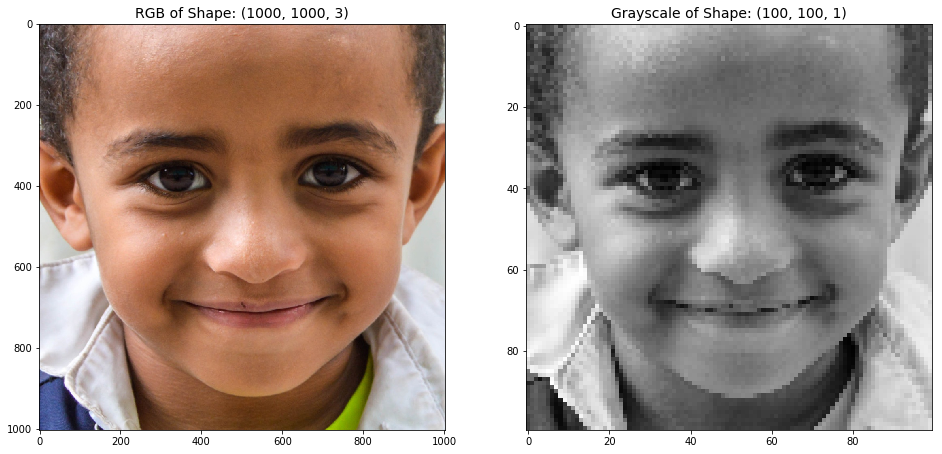

In [206]:
# Plotting a sample of resized vs. original image:
original_image = cv2.imread(root_dir + 'Manually_Annotated_compressed/Manually Annotated Images/' + file_list['subDirectory_filePath'].iloc[52])
resized_image = image_processor(original_image, (100,100))

plt.figure(figsize = (16,8))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('RGB of Shape: (1000, 1000, 3)', fontsize=14)

plt.subplot2grid((1,2), (0,1))
plt.imshow(resized_image, cmap = 'gray');
plt.title('Grayscale of Shape: (100, 100, 1)', fontsize=14);

### 3.2 Dealing with Class Imbalance

Let's re-vist the expression summary list from Part 1:

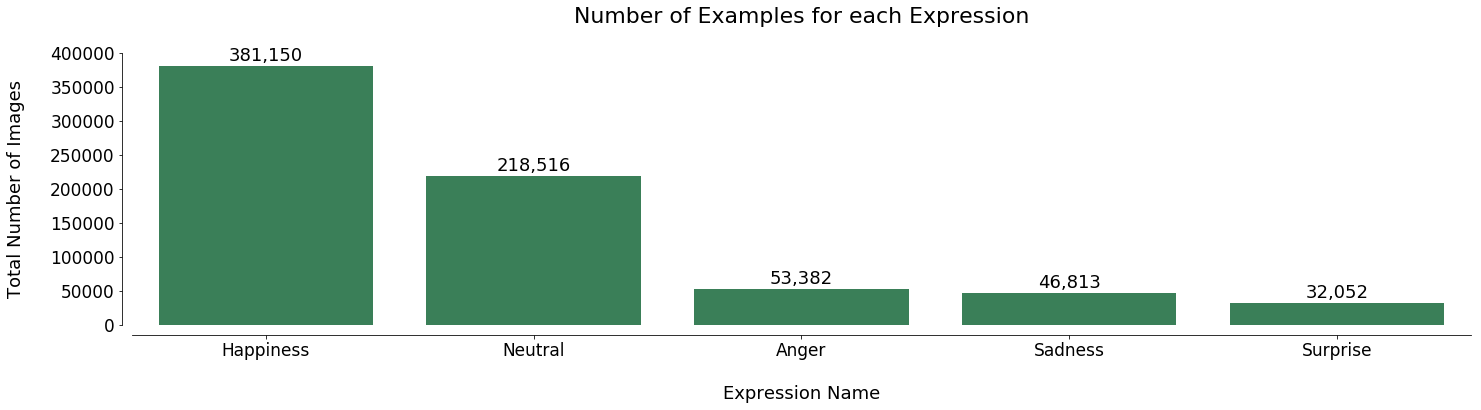

In [10]:
x = expression_summary['Expression Name']
y = expression_summary['Count (Total)']

barPlotGenarator(x, y)

As discussed in Part 1, we are dealing with considerable class imbalance. The aim of this section is to minimize such imbalance by doing the following:
1. Augmenting the minority classes (i.e. Anger, Sadness and Surprise) by flipping each image horizontally
2. Under-sampling the majority classes (i.e. Happiness and Neutral)

#### 3.2.1. Augmenting the Minority Classes
For the minority classes we will double the number of available images by flipping them horizontally. Considering the nature of the problem the new data is expected to add meaningful variation to the training set.

In [11]:
# Create new sad, surprised and angry images by flipping:
flipped_images_sad, flipped_expressions_sad = image_flipper(images_sad, expressions_sad)
flipped_images_surprised, flipped_expressions_surprised = image_flipper(images_surprised, expressions_surprised)
flipped_images_anger, flipped_expressions_anger = image_flipper(images_anger, expressions_anger)

As always let's visualize a sample image and its flipped copy:

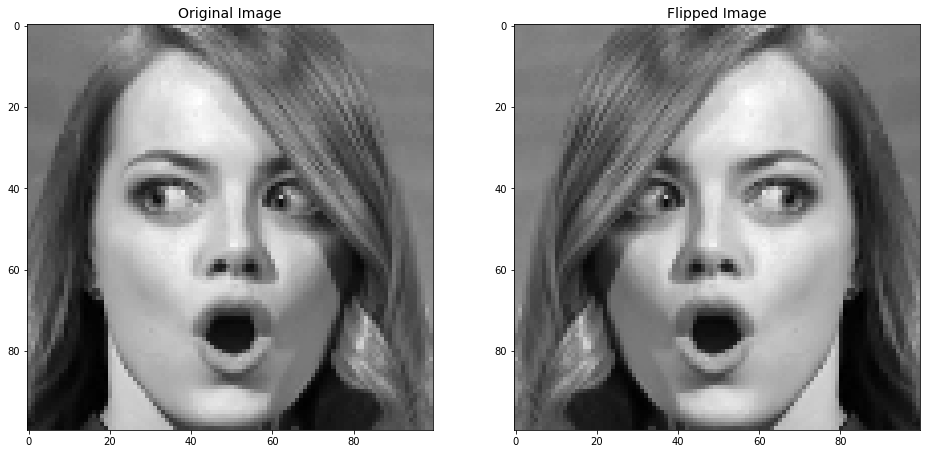

In [207]:
# Plotting a sample of origincal vs. flipped image:
plt.figure(figsize = (16,8))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.imshow(images_surprised[999], cmap = 'gray');
plt.title('Original Image', fontsize=14)

plt.subplot2grid((1,2), (0,1))
plt.imshow(flipped_images_surprised[999], cmap = 'gray');
plt.title('Flipped Image', fontsize=14);

In [12]:
# Concatenating flipped and original images:
images_sad = np.concatenate((images_sad, flipped_images_sad), axis=0)
expressions_sad = np.concatenate((expressions_sad, flipped_expressions_sad), axis=0)

images_surprised = np.concatenate((images_surprised, flipped_images_surprised), axis=0)
expressions_surprised = np.concatenate((expressions_surprised, flipped_expressions_surprised), axis=0)

images_anger = np.concatenate((images_anger, flipped_images_anger), axis=0)
expressions_anger = np.concatenate((expressions_anger, flipped_expressions_anger), axis=0)

#### 3.2.2. Under-sampling the Majority Classes 
As the next step we reduce the number of samples from the majority classes to match the available data for minority classes. First, let's update the expression summary list and re-generate the barplot from last section:



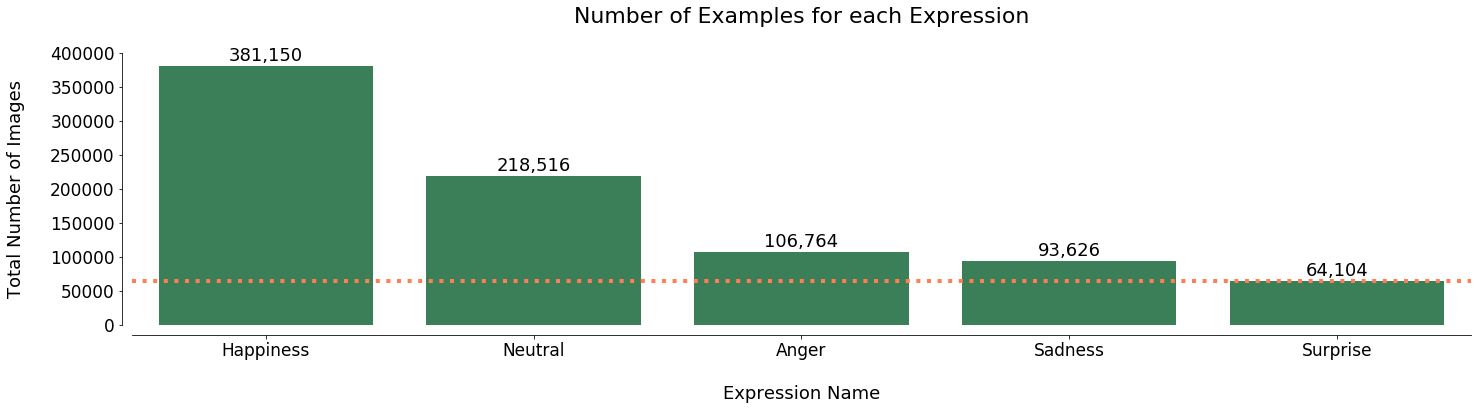

In [13]:
# Defining expression names
expression_summary_augmented = pd.DataFrame([[0, 'Neutral'], [1, 'Happiness'], [2, 'Sadness'], 
                                             [3, 'Surprise'], [6, 'Anger']], 
                                            columns = ['Expression Code', 'Expression Name'])

# Re-counting for each class
temp_list = np.concatenate((expressions_sad, expressions_surprised, expressions_happy, 
                            expressions_neutral, expressions_anger), axis=0)
unique_class, count = np.unique(temp_list, return_counts=True)
expression_summary_augmented['Count (Total)'] = count

# Sorting based on Count (Total) columns
expression_summary_augmented = expression_summary_augmented\
                                    .sort_values('Count (Total)', ascending=False)\
                                        .reset_index(drop=True)

x = expression_summary_augmented['Expression Name']
y = expression_summary_augmented['Count (Total)']

barPlotGenarator(x, y)
plt.axhline(np.min(y), color = 'coral', ls = ':', linewidth=4);

The smallest class, post augmentation, is the surprised class with about 65,000 images in total (dotted line above). Therefore we can under-sample all other classes to 70,000 images and have a balanced dataset for modelling:

In [14]:
# Concatenating all classes:
images_5classes = np.concatenate((images_sad[:70000], 
                                  images_surprised,
                                  images_happy[:70000],
                                  images_neutral[:70000],
                                  images_anger[:70000]), axis=0)
expressions_5classes = np.concatenate((expressions_sad[:70000], 
                                       expressions_surprised, 
                                       expressions_happy[:70000], 
                                       expressions_neutral[:70000], 
                                       expressions_anger[:70000]), axis=0)

# Re-counting for each class
expression_summary_final = pd.DataFrame([[1, 'Happiness'], [0, 'Neutral'], [6, 'Anger'], [2, 'Sadness'], [3, 'Surprise']], 
                                        columns = ['Expression Code', 'Expression Name'])

unique_class, count = np.unique(expressions_5classes, return_counts=True)
for i in range(len(unique_class)):
    expression_summary_final.loc[expression_summary_final['Expression Code'] == unique_class[i], 'Count (Total)'] = count[i]

The barplots below summarize how we dealt with the imbalanced classes:

**Note:** We could do further data augmentation (rotation, scaling, cropping, adding noise and so on) to increase the size of our balanced dataset, however, the current data is deemed sufficient considering the computation power limitations (on personal computer and Google Colab).

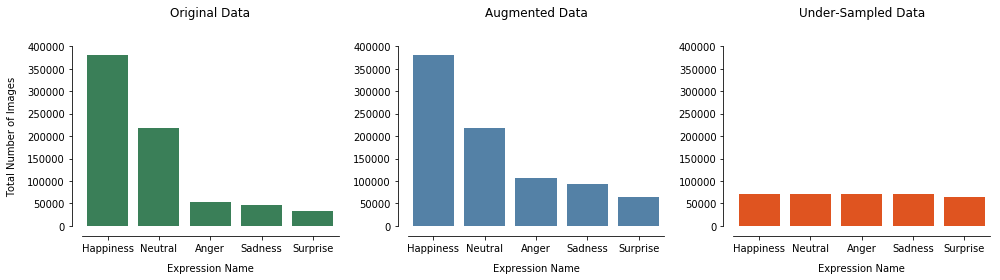

In [15]:
plt.figure(figsize = (14,4))
gridspec.GridSpec(1,3)

plt.subplot2grid((1,3), (0,0))
sns.barplot(x = expression_summary['Expression Name'],
            y = expression_summary['Count (Total)'], 
            color = 'seagreen')
sns.despine(offset=10, trim=False)
plt.title('Original Data', fontsize=12, pad = 30);
plt.xlabel('Expression Name', fontsize=10, labelpad=10)
plt.ylabel('Total Number of Images', fontsize=10, labelpad=10)
plt.ylim(0, 400000)
    
plt.subplot2grid((1,3), (0,1))
sns.barplot(x = expression_summary_augmented['Expression Name'],
            y = expression_summary_augmented['Count (Total)'], 
            color = 'steelblue')
sns.despine(offset=10, trim=False)
plt.title('Augmented Data', fontsize=12, pad = 30);
plt.xlabel('Expression Name', fontsize=10, labelpad=10)
plt.ylabel('')
plt.ylim(0, 400000)

import matplotlib

plt.subplot2grid((1,3), (0,2))
sns.barplot(x = expression_summary_final['Expression Name'], 
            y = expression_summary_final['Count (Total)'], 
            color ='orangered')
sns.despine(offset=10, trim=False)
plt.title('Under-Sampled Data', fontsize=12, pad = 30);
plt.xlabel('Expression Name', fontsize=10, labelpad=10)
plt.ylabel('')
plt.ylim(0, 400000);

plt.tight_layout()

### 3.3 Scaling

For each image, the pixel values are integers between 0 and 255, but Neural Networks usually start with small weight values and inputs with large integer values can disrupt or slow down the learning process. As such, it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. For this reason we divide the pixel values by the maximum value (255) for all images in the `images_5classes` dataset:

**Note:** We need to save the scaled data as `float16` instead of the the default `float64` to fit in the available RAM memory on Google Colab.

In [3]:
images_scaled_5classes = np.divide(images_5classes, 255, dtype = 'float16')

### 3.4 Splitting into Train, Validation and Test sets

In this part we split the data into 3 distinct sets for training, validation and testing of the model.

As discussed the model training will be done in two stream. First with all 5 classes included (Neutral, Happy, Sad, Surprised and Angry) and then with only 3 classes (Happy, Sad and Surpeised). For each stream, we will be allocating the data to training, validation and testing, as follows:

|  Dataset| Percentage | No. of Datapoints (5-Class) | No. of Datapoints (3-Class) |
|----------------|------------|-------------------------------|-------------------------------|
| Training  | 90% | 309,693 | 183,693 |
| Validation  | 5% | 17,206 | 10,206 |
| Test  | 5% | 17,205 | 10,205 |

Let's first create a new set for the three-class model (Happy, Sad and Surpeised):

In [3]:
# Selection Happy, Sad and Surprised images:
images_scaled_3classes = images_scaled_5classes[(expressions_5classes==1) | (expressions_5classes==2) | (expressions_5classes==3)]
expressions_3classes = expressions_5classes[(expressions_5classes==1) | (expressions_5classes==2) | (expressions_5classes==3)]

Using the helper function below we can now perform the splitting on both datasets:

In [4]:
# A function to split the data into train/validation/test sets:
def data_loader(images, expressions, train_size):
    
    # Train-Validation-Test split:
    X_train, X_temp, y_train, y_temp = train_test_split(images, expressions, test_size = (1-train_size), 
                                                        random_state = 1, stratify = expressions)
    del images     # Deleting to free up RAM space

    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, 
                                                    random_state = 1, stratify = y_temp)
    del X_temp     # Deleting to free up RAM space
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
X_train_5classes, X_val_5classes, X_test_5classes,\
y_train_5classes, y_val_5classes, y_test_5classes = data_loader(images = images_scaled_5classes,
                                                                expressions = expressions_5classes, 
                                                                train_size = 0.9)
del images_scaled_5classes

In [9]:
X_train_3classes, X_val_3classes, X_test_3classes,\
y_train_3classes, y_val_3classes, y_test_3classes = data_loader(images = images_scaled_3classes,
                                                                expressions = expressions_3classes, 
                                                                train_size = 0.9)
del images_scaled_3classes

### 3.5 Preparing the Data for Keras

As the last step we reshape the X data to meet the input requirements of Keras (`num_examples`, `pixel`, `pixel`, `channels`), also convert the categorical output Y to dummies:

In [6]:
# A function to reshape the data and process the categorical output:
def data_processor_Keras(X_train, X_val, X_test, y_train, y_val, y_test, input_pixel):
    
    # Reshaping to meet Keras shape requirement:
    X_train = X_train.reshape(X_train.shape[0], input_pixel, input_pixel, 1)
    X_test = X_test.reshape(X_test.shape[0], input_pixel, input_pixel, 1)
    X_val = X_val.reshape(X_val.shape[0], input_pixel, input_pixel, 1)

    # Converting categorical response to dummies:
    y_train = np.asarray(pd.get_dummies(y_train))
    y_test = np.asarray(pd.get_dummies(y_test))
    y_val = np.asarray(pd.get_dummies(y_val))

    print(f'X_train shape:\t{X_train.shape}')
    print(f'y_train shape:\t{y_train.shape}')
    print(f'X_val shape:\t{X_val.shape}')
    print(f'y_val shape:\t{y_val.shape}')
    print(f'X_test shape:\t{X_test.shape}')
    print(f'y_test shape:\t{y_test.shape}')
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_train_5classes, X_val_5classes,\
X_test_5classes, y_train_5classes,\
y_val_5classes, y_test_5classes = data_processor_Keras(X_train_5classes, X_val_5classes, X_test_5classes, 
                                                       y_train_5classes, y_val_5classes, y_test_5classes, 
                                                       input_pixel = 100)

X_train shape:	(309693, 100, 100, 1)
y_train shape:	(309693, 5)
X_val shape:	(17206, 100, 100, 1)
y_val shape:	(17206, 5)
X_test shape:	(17205, 100, 100, 1)
y_test shape:	(17205, 5)


In [10]:
X_train_3classes, X_val_3classes,\
X_test_3classes, y_train_3classes,\
y_val_3classes, y_test_3classes = data_processor_Keras(X_train_3classes, X_val_3classes, X_test_3classes, 
                                                       y_train_3classes, y_val_3classes, y_test_3classes, 
                                                       input_pixel = 100)

X_train shape:	(183693, 100, 100, 1)
y_train shape:	(183693, 3)
X_val shape:	(10206, 100, 100, 1)
y_val shape:	(10206, 3)
X_test shape:	(10205, 100, 100, 1)
y_test shape:	(10205, 3)


---
## 4. Data Exporting

The processed data can now be exported as `.npy` files to be used for model training in the next part.

In [8]:
# Saving all 5 classes as npy files:
np.save('Data/5 Expressions/X_train_5classes.npy', X_train_5classes)
np.save('Data/5 Expressions/X_test_5classes.npy', X_test_5classes)
np.save('Data/5 Expressions/X_val_5classes.npy', X_val_5classes)

np.save('Data/5 Expressions/y_train_5classes.npy', y_train_5classes)
np.save('Data/5 Expressions/y_test_5classes.npy', y_test_5classes)
np.save('Data/5 Expressions/y_val_5classes.npy', y_val_5classes)

In [12]:
# Saving all 3 classes as npy files:
np.save('Data/3 Expressions/X_train_3classes.npy', X_train_3classes)
np.save('Data/3 Expressions/X_test_3classes.npy', X_test_3classes)
np.save('Data/3 Expressions/X_val_3classes.npy', X_val_3classes)

np.save('Data/3 Expressions/y_train_3classes.npy', y_train_3classes)
np.save('Data/3 Expressions/y_test_3classes.npy', y_test_3classes)
np.save('Data/3 Expressions/y_val_3classes.npy', y_val_3classes)